## Data Analysis UBE project Market Size prediction - Notebook Data_Exploration (1)

**Status:** CONFIDENTIAL DO NOT PUBLISH OR DISTRIBUTE OUTSIDE UBE <br>

**Author:** Javier Vicente Napolitano / Jaume Manero T4S<br>
**Date created:** 2021/02/1<br>
**Last modified:** <br>
**Description:** Several analysis on data to support prediction algorithm design

In [7]:
import pandas as pd
import seaborn as sn
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import xgboost
from xgboost import XGBRegressor
import seaborn as sns
from scipy.interpolate import make_interp_spline
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from collections import defaultdict

In [9]:
gas_path   = './data/gas_data.csv'
fut_path_m = './data/Natural Gas Prices (Monthly).csv'
df_gas = pd.read_csv(gas_path) 
print('hay ', df_gas.isnull().sum().sum(), 'nans en el dataframe',gas_path)
df_fut_m = pd.read_csv(fut_path_m) 
print('hay ', df_fut_m.isnull().sum().sum(), 'nans en el dataframe',fut_path_m)
df_fut_m = df_fut_m.fillna(0)

hay  0 nans en el dataframe ./data/gas_data.csv
hay  229 nans en el dataframe ./data/Natural Gas Prices (Monthly).csv


##### ========================================================================================================================
### GAS Analysis
##### ========================================================================================================================

In [10]:
# Transform GAS into time Series

df_gas_g = df_gas.groupby(by=['Year', 'Month Num']).mean()
df_gas_g = df_gas_g.reset_index()
df_gas_g['YearMonthNum'] = df_gas_g['Year']*100 + df_gas_g['Month Num']
df_gas_g['Date'] = pd.to_datetime(df_gas_g['YearMonthNum'], format='%Y%m')
df_gas_g.head()

,Year,Month Num,Year/Month,Spot TTF Price (€/MWh),Week Num,YearMonthNum,Date
0,2017,1,1.2017,20.05,2.5,201701,2017-01-01
1,2017,2,2.2017,19.83,7.0,201702,2017-02-01
2,2017,3,3.2017,15.85,11.0,201703,2017-03-01
3,2017,4,4.2017,16.08,15.0,201704,2017-04-01
4,2017,5,5.2017,15.66,20.0,201705,2017-05-01


In [11]:
# Transform df_fut_m to Time Series
# Transform file into Time series 

df_fut_m = df_fut_m.reset_index()
df_fut_m['YearMonthNum'] = df_fut_m['Year']*100 + df_fut_m['Month Num']
df_fut_m['Date'] = pd.to_datetime(df_fut_m['YearMonthNum'], format='%Y%m')
df_fut_m.columns

Index(['index', 'Year', 'Year-Month', 'Year/Month', 'Month Num',
       'Spot TTF Price', 'TTF Future Price', 'TTF Future Price M+1',
       'TTF Future Price M+2', 'TTF Future Price M+3', 'TTF Future Price M+4',
       'TTF Future Price M+5', 'TTF Future Price M+6', 'DHHNGSP FC1',
       'DHHNGSP FC1 M+1', 'DHHNGSP FC1 M+2', 'DHHNGSP FC1 M+3',
       'DHHNGSP FC1 M+4', 'DHHNGSP FC1 M+5', 'DHHNGSP FC1 M+6', 'DHHNGSP FC2',
       'DHHNGSP FC2 M+1', 'DHHNGSP FC2 M+2', 'DHHNGSP FC2 M+3',
       'DHHNGSP FC2 M+4', 'DHHNGSP FC2 M+5', 'DHHNGSP FC2 M+6', 'DHHNGSP FC3',
       'DHHNGSP FC3 M+1', 'DHHNGSP FC3 M+2', 'DHHNGSP FC3 M+3',
       'DHHNGSP FC3 M+4', 'DHHNGSP FC3 M+5', 'DHHNGSP FC3 M+6', 'DHHNGSP FC4',
       'DHHNGSP FC4 M+1', 'DHHNGSP FC4 M+2', 'DHHNGSP FC4 M+3',
       'DHHNGSP FC4 M+4', 'DHHNGSP FC4 M+5', 'DHHNGSP FC4 M+6', 'YearMonthNum',
       'Date'],
      dtype='object')

In [14]:
start_date = df_gas_g['Date'].min()
end_date  = df_gas_g['Date'].max()


mask = (df_fut_m['Date'] >= start_date) & (df_fut_m['Date'] <= end_date)
df_tmp = df_fut_m[mask]
df_tmp = df_tmp.reset_index()
df_tmp = df_tmp.drop(['level_0', 'index'], axis=1)
df_tmp

,Year,Year-Month,Year/Month,Month Num,Spot TTF Price,TTF Future Price,TTF Future Price M+1,TTF Future Price M+2,TTF Future Price M+3,TTF Future Price M+4,...,DHHNGSP FC3 M+6,DHHNGSP FC4,DHHNGSP FC4 M+1,DHHNGSP FC4 M+2,DHHNGSP FC4 M+3,DHHNGSP FC4 M+4,DHHNGSP FC4 M+5,DHHNGSP FC4 M+6,YearMonthNum,Date
0,2017,2017-01,1.2017,1,20.05,20.093167,17.79240,15.803200,15.962000,15.229000,...,2.990000,3.348167,3.1302,3.183800,3.359400,3.301200,3.053400,3.072833,201701,2017-01-01
1,2017,2017-02,2.2017,2,19.83,17.792400,15.80320,15.962000,15.229000,14.768400,...,3.028400,3.130200,3.1838,3.359400,3.301200,3.053400,3.072833,3.168200,201702,2017-02-01
2,2017,2017-03,3.2017,3,15.85,15.803200,15.96200,15.229000,14.768400,15.048667,...,3.209400,3.183800,3.3594,3.301200,3.053400,3.072833,3.168200,3.308000,201703,2017-03-01
3,2017,2017-04,4.2017,4,16.08,15.962000,15.22900,14.768400,15.048667,16.322800,...,3.193167,3.359400,3.3012,3.053400,3.072833,3.168200,3.308000,3.203667,201704,2017-04-01
4,2017,2017-05,5.2017,5,15.66,15.229000,14.76840,15.048667,16.322800,17.212600,...,3.138800,3.301200,3.0534,3.072833,3.168200,3.308000,3.203667,3.087600,201705,2017-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2022,2022-11,11.2022,11,90.99,122.481400,96.67800,61.417500,50.368800,44.965750,...,0.000000,5.716200,4.7592,3.343000,2.937000,3.292000,0.000000,0.000000,202211,2022-11-01
71,2022,2022-12,12.2022,12,117.10,96.678000,61.41750,50.368800,44.965750,0.000000,...,0.000000,4.759200,3.3430,2.937000,3.292000,0.000000,0.000000,0.000000,202212,2022-12-01
72,2023,2023-01,1.2023,1,64.05,61.417500,50.36880,44.965750,0.000000,0.000000,...,0.000000,3.343000,2.9370,3.292000,0.000000,0.000000,0.000000,0.000000,202301,2023-01-01
73,2023,2023-02,2.2023,2,53.84,50.368800,44.96575,0.000000,0.000000,0.000000,...,0.000000,2.937000,3.2920,0.000000,0.000000,0.000000,0.000000,0.000000,202302,2023-02-01


In [15]:
df_gas_g['gas_fut_1'] = df_tmp['TTF Future Price M+1']
df_gas_g['gas_fut_2'] = df_tmp['TTF Future Price M+2']
df_gas_g['gas_fut_3'] = df_tmp['TTF Future Price M+3']
df_gas_g['gas_fut_4'] = df_tmp['TTF Future Price M+4']
df_gas_g['gas_fut_5'] = df_tmp['TTF Future Price M+5']
df_gas_g['gas_fut_6'] = df_tmp['TTF Future Price M+6']
df_gas_g['DHHNGSP FC1'] = df_tmp['DHHNGSP FC1']
df_gas_g['DHHNGSP FC2'] = df_tmp['DHHNGSP FC2']
df_gas_g['DHHNGSP FC3'] = df_tmp['DHHNGSP FC3']
df_gas_g['DHHNGSP FC4'] = df_tmp['DHHNGSP FC4']


In [16]:
df_gas_g

,Year,Month Num,Year/Month,Spot TTF Price (€/MWh),Week Num,YearMonthNum,Date,gas_fut_1,gas_fut_2,gas_fut_3,gas_fut_4,gas_fut_5,gas_fut_6,DHHNGSP FC1,DHHNGSP FC2,DHHNGSP FC3,DHHNGSP FC4
0,2017,1,1.2017,20.05,2.5,201701,2017-01-01,17.79240,15.803200,15.962000,15.229000,14.768400,15.048667,3.362333,3.363667,3.351000,3.348167
1,2017,2,2.2017,19.83,7.0,201702,2017-02-01,15.80320,15.962000,15.229000,14.768400,15.048667,16.322800,2.904000,2.996200,3.065000,3.130200
2,2017,3,3.2017,15.85,11.0,201703,2017-03-01,15.96200,15.229000,14.768400,15.048667,16.322800,17.212600,2.971600,3.047400,3.120600,3.183800
3,2017,4,4.2017,16.08,15.0,201704,2017-04-01,15.22900,14.768400,15.048667,16.322800,17.212600,18.204333,3.180400,3.262000,3.331200,3.359400
4,2017,5,5.2017,15.66,20.0,201705,2017-05-01,14.76840,15.048667,16.322800,17.212600,18.204333,20.145200,3.210000,3.286400,3.310800,3.301200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2022,11,11.2022,90.99,46.0,202211,2022-11-01,96.67800,61.417500,50.368800,44.965750,0.000000,0.000000,6.454800,6.759000,6.458200,5.716200
71,2022,12,12.2022,117.10,50.0,202212,2022-12-01,61.41750,50.368800,44.965750,0.000000,0.000000,0.000000,5.870200,5.725600,5.220400,4.759200
72,2023,1,1.2023,64.05,2.5,202301,2023-01-01,50.36880,44.965750,0.000000,0.000000,0.000000,0.000000,3.560333,3.355333,3.287833,3.343000
73,2023,2,2.2023,53.84,7.0,202302,2023-02-01,44.96575,0.000000,0.000000,0.000000,0.000000,0.000000,2.500400,2.594000,2.747600,2.937000


<AxesSubplot:title={'center':'Gas prices'}, xlabel='Date'>

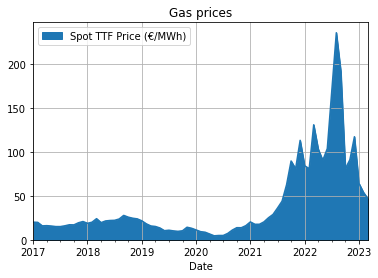

In [17]:
df_gas_g.plot(kind='area', x='Date', y='Spot TTF Price (€/MWh)', title='Gas prices', grid=True)

In [18]:
df_gas_g

,Year,Month Num,Year/Month,Spot TTF Price (€/MWh),Week Num,YearMonthNum,Date,gas_fut_1,gas_fut_2,gas_fut_3,gas_fut_4,gas_fut_5,gas_fut_6,DHHNGSP FC1,DHHNGSP FC2,DHHNGSP FC3,DHHNGSP FC4
0,2017,1,1.2017,20.05,2.5,201701,2017-01-01,17.79240,15.803200,15.962000,15.229000,14.768400,15.048667,3.362333,3.363667,3.351000,3.348167
1,2017,2,2.2017,19.83,7.0,201702,2017-02-01,15.80320,15.962000,15.229000,14.768400,15.048667,16.322800,2.904000,2.996200,3.065000,3.130200
2,2017,3,3.2017,15.85,11.0,201703,2017-03-01,15.96200,15.229000,14.768400,15.048667,16.322800,17.212600,2.971600,3.047400,3.120600,3.183800
3,2017,4,4.2017,16.08,15.0,201704,2017-04-01,15.22900,14.768400,15.048667,16.322800,17.212600,18.204333,3.180400,3.262000,3.331200,3.359400
4,2017,5,5.2017,15.66,20.0,201705,2017-05-01,14.76840,15.048667,16.322800,17.212600,18.204333,20.145200,3.210000,3.286400,3.310800,3.301200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2022,11,11.2022,90.99,46.0,202211,2022-11-01,96.67800,61.417500,50.368800,44.965750,0.000000,0.000000,6.454800,6.759000,6.458200,5.716200
71,2022,12,12.2022,117.10,50.0,202212,2022-12-01,61.41750,50.368800,44.965750,0.000000,0.000000,0.000000,5.870200,5.725600,5.220400,4.759200
72,2023,1,1.2023,64.05,2.5,202301,2023-01-01,50.36880,44.965750,0.000000,0.000000,0.000000,0.000000,3.560333,3.355333,3.287833,3.343000
73,2023,2,2.2023,53.84,7.0,202302,2023-02-01,44.96575,0.000000,0.000000,0.000000,0.000000,0.000000,2.500400,2.594000,2.747600,2.937000


<function matplotlib.pyplot.show(close=None, block=None)>

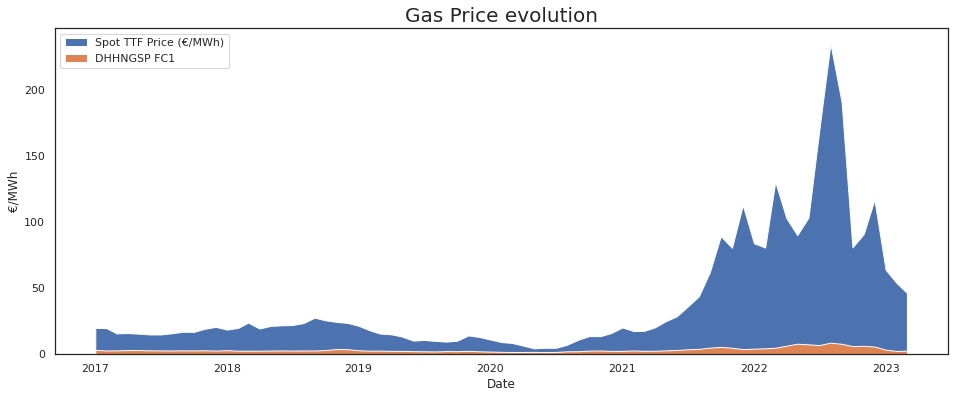

In [19]:

colors = sns.color_palette("PRGn", 7)
#df['MA Delivered Quantity'] = df.rolling(window=5).mean()
#df['MA Order Quantity'] = df.rolling(window=5).mean()
col1 = 'Spot TTF Price (€/MWh)'
col2 = 'DHHNGSP FC1'
col3 = 'DHHNGSP FC2'
col4 = 'DHHNGSP FC3'
col5 = 'DHHNGSP FC4'
plt.figure(figsize=(16, 6))
sns.set(style = 'white')
y = df_gas_g[col1]
y1 = df_gas_g[col2]
x = df_gas_g['Date']
plt.stackplot(x, y, labels=[col1], )
plt.stackplot(x, y1, labels=[col2])
plt.title('Gas Price evolution', fontsize = 20)
plt.xlabel('Date')
plt.ylabel('€/MWh')
plt.legend(loc="upper left")
#plt.ylim(0,40000)
plt.show
#print(df_g[''.to_markdown())

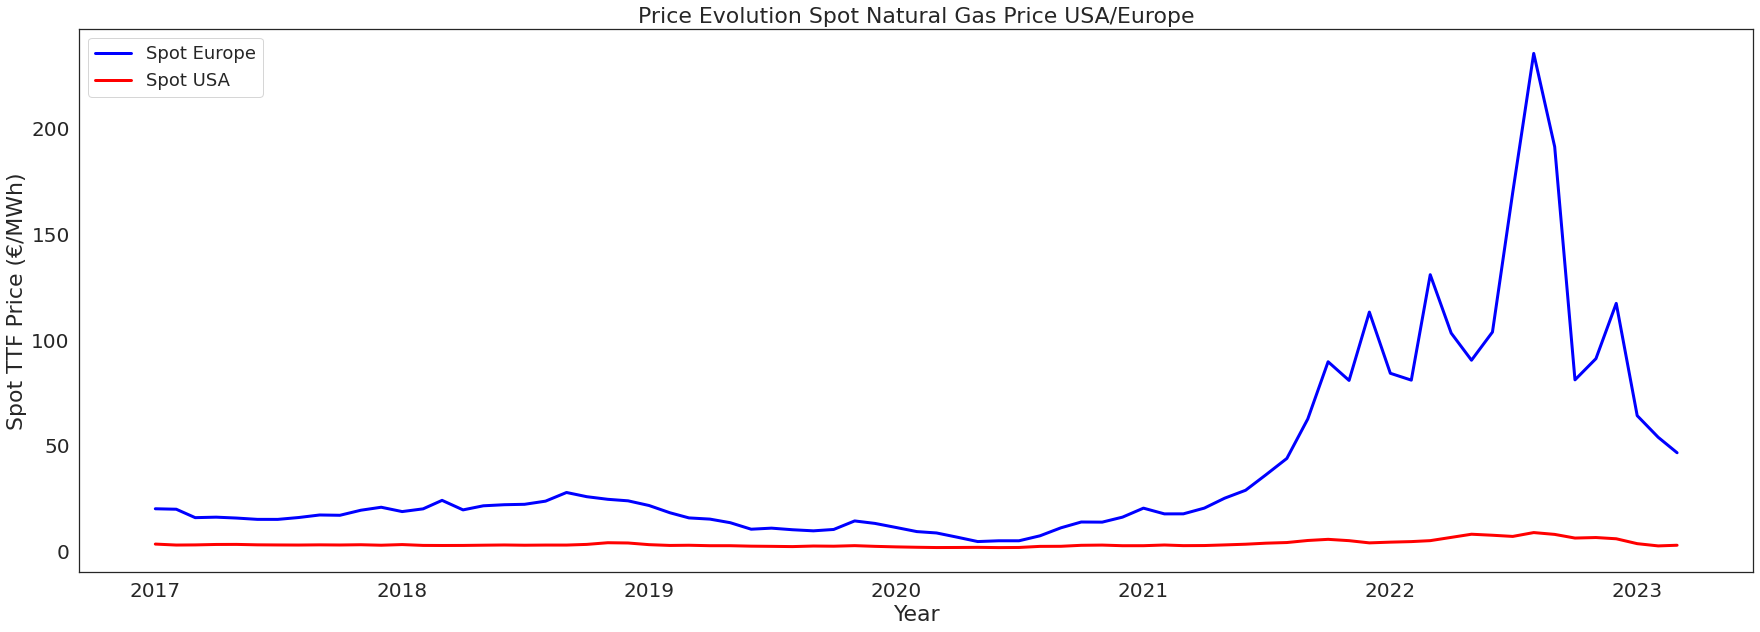

In [20]:
# Dataset Visualization

fig, ax = plt.subplots(figsize=(30,10))

ax.plot(df_gas_g['Date'],df_gas_g[col1],color='blue',linewidth=3.0,label='Spot Europe')
ax.plot(df_gas_g['Date'],df_gas_g[col2],color='red',linewidth=3.0,label='Spot USA')

#ax.scatter(df['date'],df['DCOILBRENTEU'],color='red',s=100.)
plt.title('Price Evolution Spot Natural Gas Price USA/Europe', size=22)
plt.ylabel(col1, size=22)
plt.xlabel("Year", size=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc="upper left",fontsize = 18)
#plt.savefig("figure_image.jpg")
plt.show()

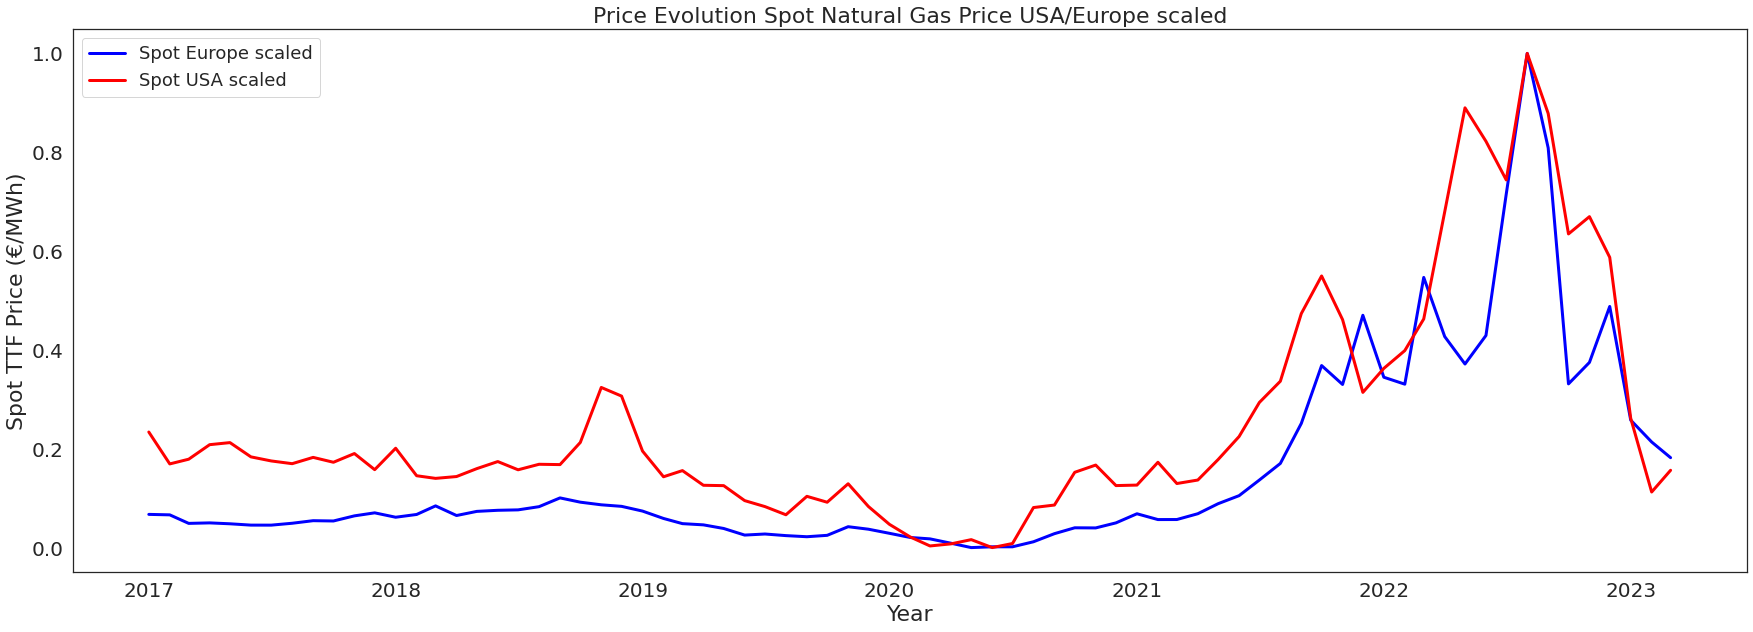

In [21]:
# Dataset Visualization
# First we create two columns

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() 

df_gas_g['GAS EUROPE'] = scaler.fit_transform(df_gas_g[[col1]])
df_gas_g['GAS USA'] = scaler.fit_transform(df_gas_g[[col2]])


fig, ax = plt.subplots(figsize=(30,10))

ax.plot(df_gas_g['Date'],df_gas_g['GAS EUROPE'],color='blue',linewidth=3.0,label='Spot Europe scaled')
ax.plot(df_gas_g['Date'],df_gas_g['GAS USA'],color='red',linewidth=3.0,label='Spot USA scaled')

#ax.scatter(df['date'],df['DCOILBRENTEU'],color='red',s=100.)
plt.title('Price Evolution Spot Natural Gas Price USA/Europe scaled', size=22)
plt.ylabel(col1, size=22)
plt.xlabel("Year", size=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc="upper left",fontsize = 18)
#plt.savefig("figure_image.jpg")
plt.show()

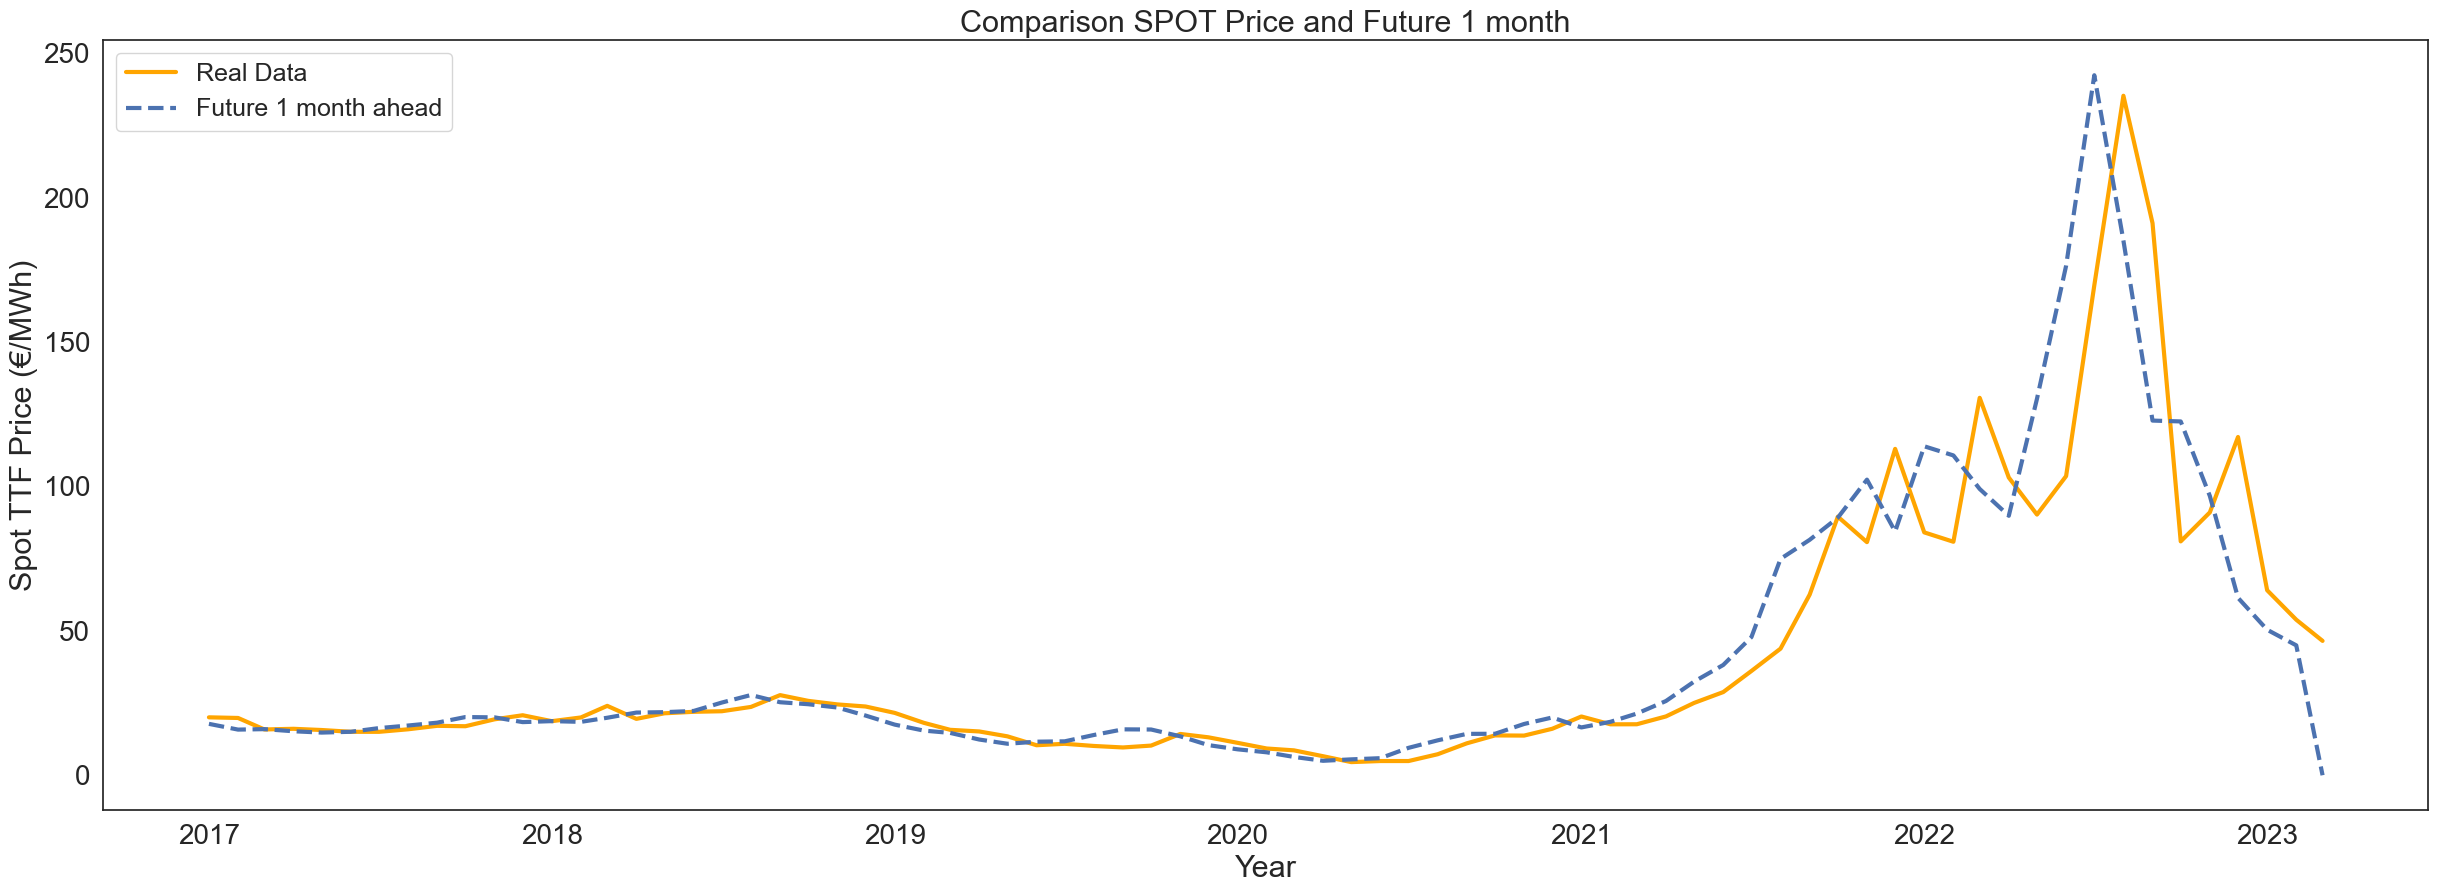

In [63]:
# Gas Prices with futures

col_fut= 'gas_fut_1'

fig, ax = plt.subplots(figsize=(30,10))

ax.plot(df_gas_g['Date'],df_gas_g[col1],color='orange',linewidth=3.0, label='Real Data') 

ax.plot(df_gas_g['Date'],df_gas_g[col_fut],linewidth=3.0, label='Future 1 month ahead', 
           linestyle='--')
#ax.scatter(df['date'],df['DCOILBRENTEU'],color='red',s=100
plt.title('Comparison SPOT Price and Future 1 month', size=22)
plt.ylabel(col1, size=22)
plt.xlabel("Year", size=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc="upper left",fontsize = 18)

#plt.savefig("figure_image.jpg")
plt.show()

In [64]:
# precission assesment
from sklearn.metrics import r2_score
r2_score(df_gas_g[col1], df_gas_g[col_fut])


0.7848965555134007

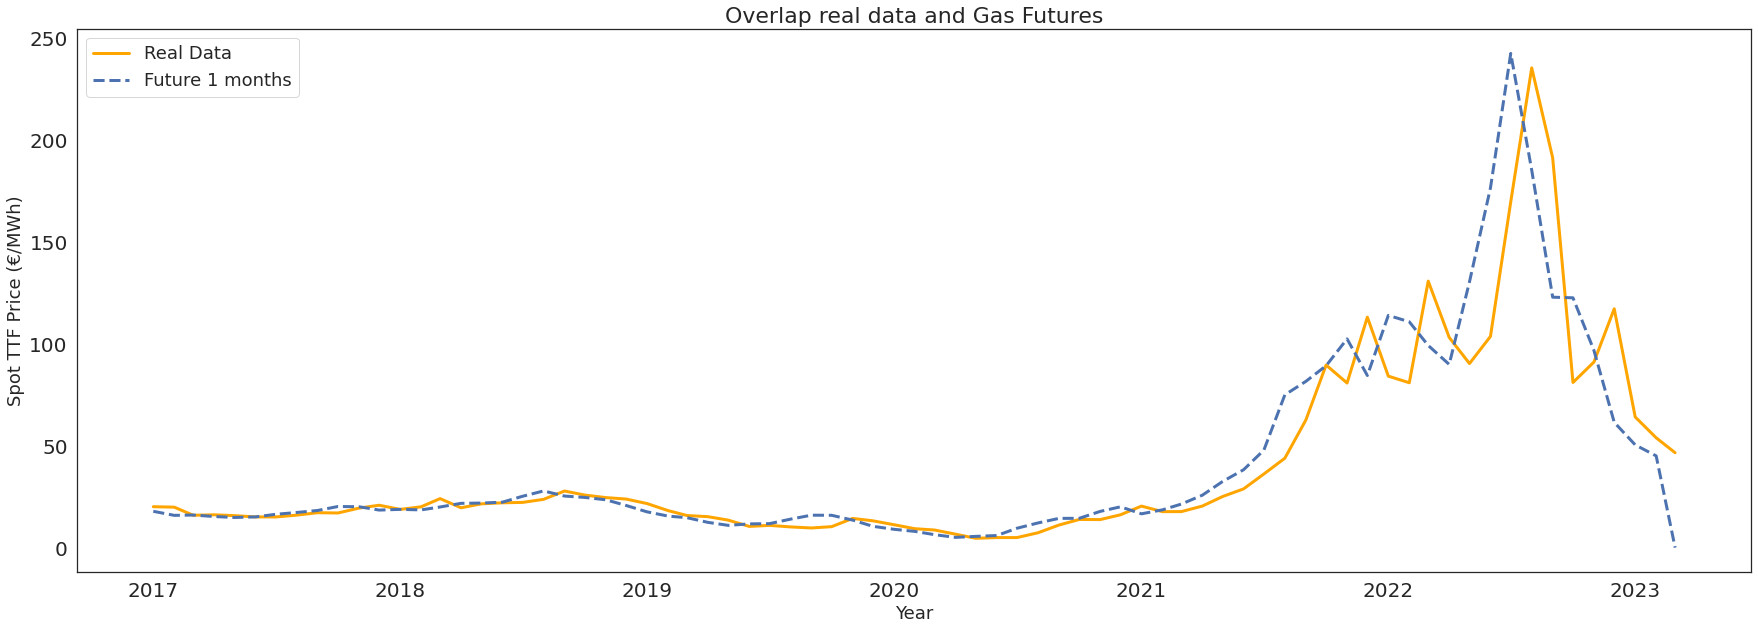

In [22]:
# Gas Prices with futures

col_fut= 'gas_fut_1'

fig, ax = plt.subplots(figsize=(30,10))

ax.plot(df_gas_g['Date'],df_gas_g[col1],color='orange',linewidth=3.0, label='Real Data') 

ax.plot(df_gas_g['Date'],df_gas_g[col_fut],linewidth=3.0, label='Future 1 months', 
           linestyle='--')
#ax.scatter(df['date'],df['DCOILBRENTEU'],color='red',s=100
plt.title('Overlap real data and Gas Futures', size=22)
plt.ylabel(col1, size=18)
plt.xlabel("Year", size=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc="upper left",fontsize = 18)

#plt.savefig("figure_image.jpg")
plt.show()

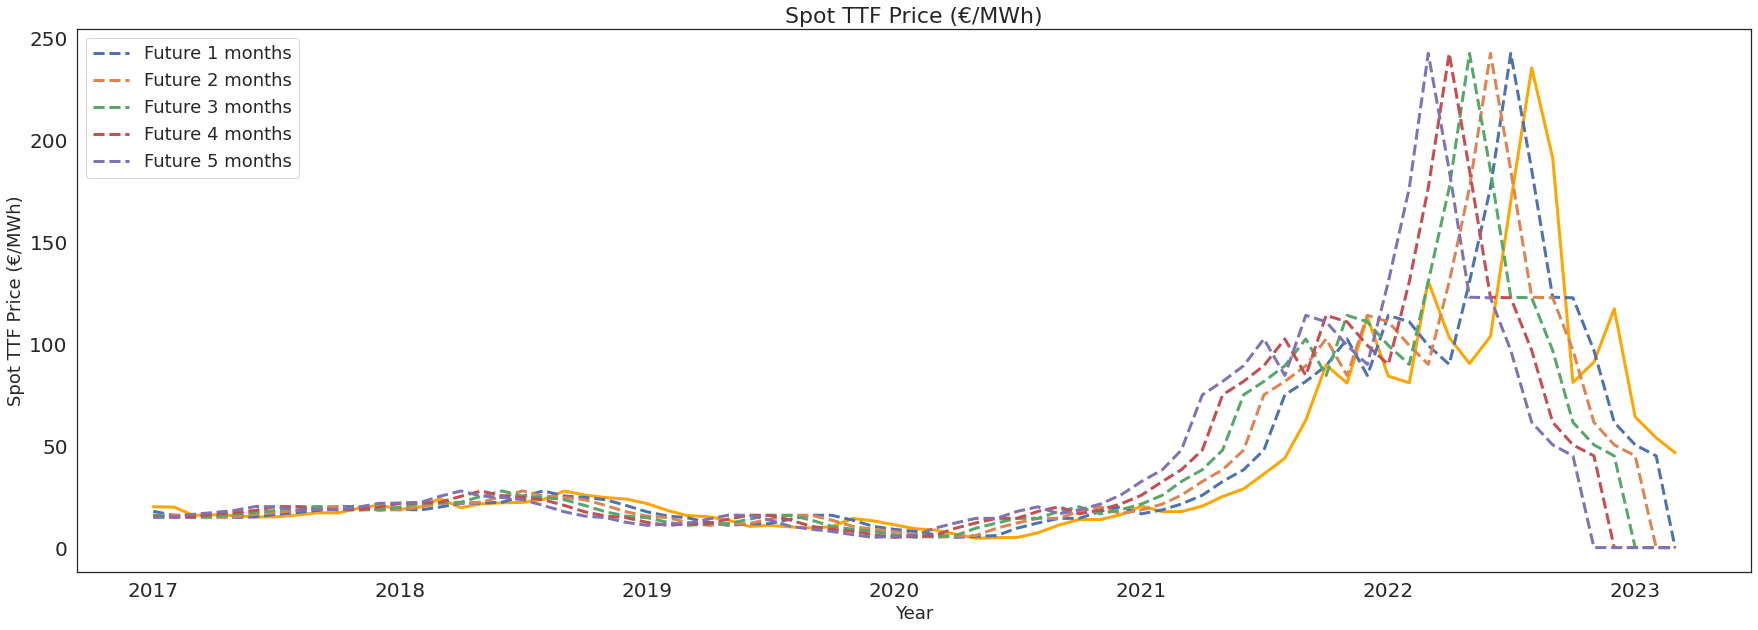

In [23]:
# Gas Prices with futures

col_fut= 'gas_fut_'

fig, ax = plt.subplots(figsize=(30,10))

ax.plot(df_gas_g['Date'],df_gas_g[col1],color='orange',linewidth=3.0)

for i in range(1,6):
   ax.plot(df_gas_g['Date'],df_gas_g[col_fut+str(i)],linewidth=3.0, label='Future '+str(i)+' months', 
           linestyle='--')
#ax.scatter(df['date'],df['DCOILBRENTEU'],color='red',s=100
plt.title(col1, size=22)
plt.ylabel(col1, size=18)
plt.xlabel("Year", size=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc="upper left",fontsize = 18)

#plt.savefig("figure_image.jpg")
plt.show()